In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import sklearn.metrics as metrics
import boto3
import io
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Proyecto Final (1ra alternativa)
Nombre: Gabriela Allende

Codigo: 50711

## 2. Conexion a S3
Consuma el archivo CSV desde su bucket en S3 desde el entorno de ejecución (Notebook o Studio). 

Puntaje: 20 pts

In [3]:
df = pd.read_csv('../animal-condition-clean.csv')
df.head()

,Animal,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Dangerous
0,dog,fever,diarrhoea,vomit,weight loss,dehydration,yes
1,dog,fever,diarrhoea,cough,tiredness,pain,yes
2,dog,fever,diarrhoea,cough,vomit,anorexia,yes
3,dog,fever,breathing difficulty,cough,lethargy,sneering,yes
4,dog,fever,diarrhoea,cough,lethargy,blue eye,yes


## 3. EDA Analisis Exploratorio de Datos
Realice un EDA (análisis exploratorio de datos) y explique las variables en cuestión.

Puntaje: 10 pts

In [5]:
df.head()

,Animal,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Dangerous
0,dog,fever,diarrhoea,vomit,weight loss,dehydration,yes
1,dog,fever,diarrhoea,cough,tiredness,pain,yes
2,dog,fever,diarrhoea,cough,vomit,anorexia,yes
3,dog,fever,breathing difficulty,cough,lethargy,sneering,yes
4,dog,fever,diarrhoea,cough,lethargy,blue eye,yes


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869 entries, 0 to 868
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Animal     869 non-null    object
 1   Symptom 1  869 non-null    object
 2   Symptom 2  869 non-null    object
 3   Symptom 3  869 non-null    object
 4   Symptom 4  869 non-null    object
 5   Symptom 5  869 non-null    object
 6   Dangerous  869 non-null    object
dtypes: object(7)
memory usage: 47.7+ KB


Dangerous
yes    849
no      20
Name: count, dtype: int64

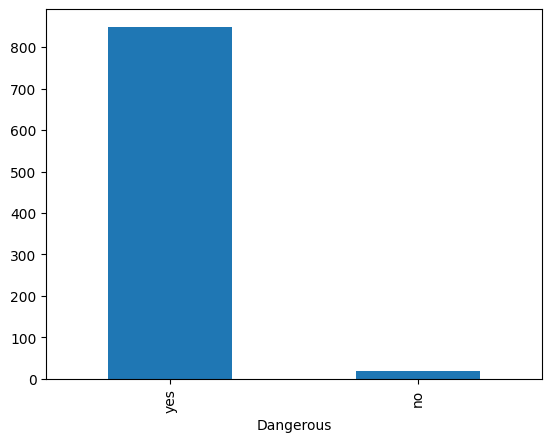

In [16]:

df_dang = df['Dangerous'].value_counts()
df_dang.plot(kind = "bar")
df_dang

In [7]:
def barPlotByCol(col):
    temp = df.groupby(col)['Animal'].count().reset_index(name='count')
    plt.bar(temp[col], temp['count'])
    plt.ylabel('Cantidad')
    plt.xlabel(col.title())
    plt.xticks(rotation=90)
    plt.title('Cantidad de animales por '+ col.title())

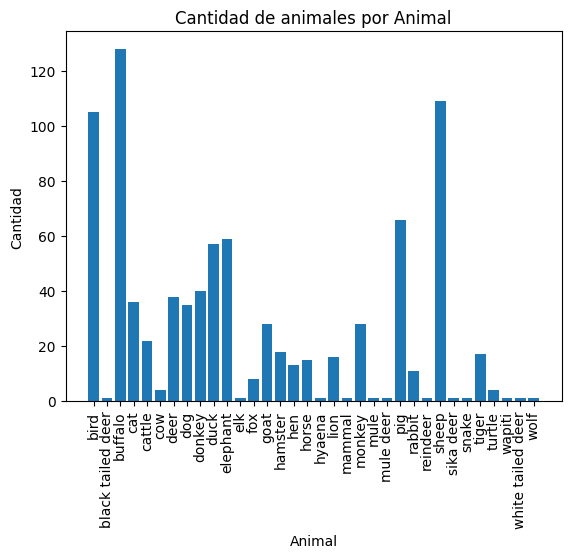

In [27]:
barPlotByCol('Animal')

In [21]:
df.groupby('Symptom 1')['Animal'].count().reset_index(name='count').sort_values('count', ascending=False)

,Symptom 1,count
68,fever,271
67,fetopelvic dispropotion,21
34,decreased appetite,20
197,wasting,20
172,sudden death,12
...,...,...
93,inflammation,1
94,isolation from flock,1
85,headache,1
45,dizziness,1


<Axes: xlabel='Animal'>

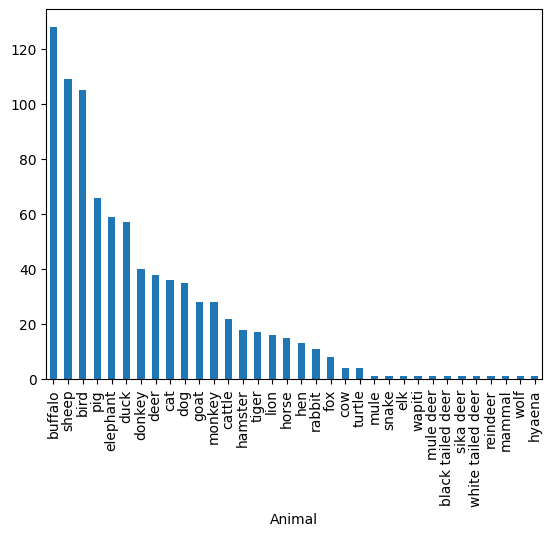

In [12]:
df['Animal'].value_counts().plot(kind = "bar")

In [6]:
def singAnimalTopClass(x):
    names = x.split()
    last = names.pop()
    return last

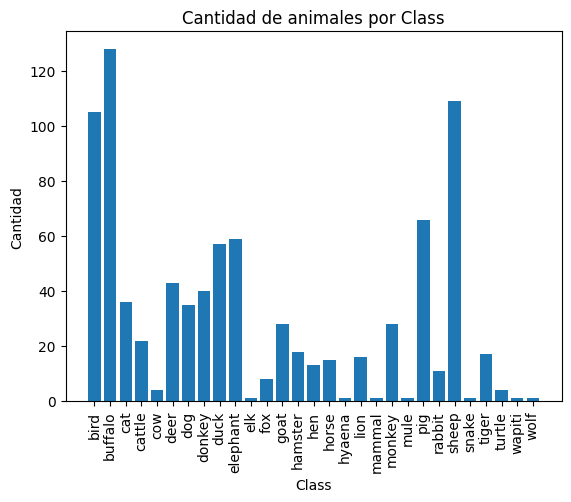

In [8]:
df['Class'] = df['Animal'].apply(lambda x: singAnimalTopClass(x) if type(x) == str else x)
df['Class'][df['Class'].str.contains("deer") ] = 'deer'
barPlotByCol('Class')

In [15]:
df.tail()

,Animal,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Dangerous,Class
864,buffalo,fever,breathing difficulty,decreased appetite,eye and skin change,unable to exercise,yes,buffalo
865,buffalo,fever,decreased appetite,lesion,lethargy,joint pain,yes,buffalo
866,buffalo,lesions in the nasal cavity,lesions on nose,vomit,noisy breathing,lesions on nose,yes,buffalo
867,buffalo,hair loss,dandruff,vomit,crushing of the skin,ulcerated skin,yes,buffalo
868,buffalo,greenish yellow nasal discharge,lack of pigmentation,vomit,lethargy,pain on face,yes,buffalo


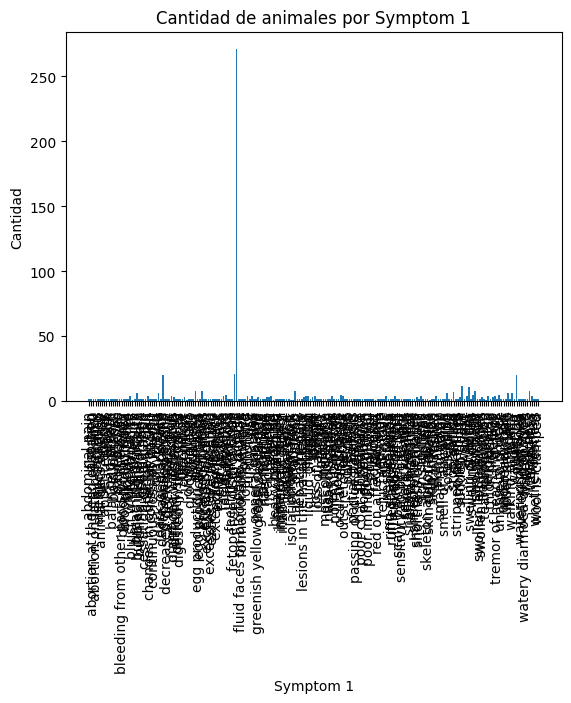

In [16]:
barPlotByCol('Symptom 1')

In [17]:
df.describe()

,Animal,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Dangerous,Class
count,869,869,869,869,869,869,869,869
unique,34,208,209,206,196,182,2,29
top,buffalo,fever,diarrhoea,cough,weight loss,pain,yes,buffalo
freq,128,271,125,97,117,167,849,128


In [18]:
df['Dangerous'].unique()

array(['yes', 'no'], dtype=object)

In [14]:
def formatSymptom(symp):
    temp = symp.strip().split()
    t2 = ' '.join(temp)
    return t2.lower()


In [15]:
all_symptoms = np.concatenate((df['Symptom 1'].unique(), df['Symptom 2'].unique(), df['Symptom 3'].unique(), df['Symptom 4'].unique(), df['Symptom 5'].unique()), axis=None)
np.unique(all_symptoms).shape

(740,)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869 entries, 0 to 868
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Animal     869 non-null    object
 1   Symptom 1  869 non-null    object
 2   Symptom 2  869 non-null    object
 3   Symptom 3  869 non-null    object
 4   Symptom 4  869 non-null    object
 5   Symptom 5  869 non-null    object
 6   Dangerous  869 non-null    object
 7   Class      869 non-null    object
dtypes: object(8)
memory usage: 54.4+ KB


### Explicacion
La base de datos contenia 7 columnas originalmente:
- 5 columnas para los sintomas de los animales (cada animal presenta 5 sintomas)
- 1 columna con el nombre de la especie del animal
- 1 columna que indica si la condicion medica es peligrosa (Dangerous)

Adicionalmente, se agrego una columna ('Class')con los nombres de los animales y las especies de Ciervos('Deer') agrupados.

La base de datos contiene 34 especies (columna 'Animal') de animales, los cuales se reducen a 30 en la columna 'Class'

Existen 740 sintomas distintos para los animales.

### Data Encoding
Se utilizara la codificacion numerica como herramienta para mejorar el rendimiento del modelo.

In [9]:
def encode(df, cols):
    unique_values = set()
    for col in cols:
        curr_unique = list(df[col].unique())
        for ele in curr_unique:
            unique_values.add(ele)
    unique_values = list(unique_values)
    unique_values.sort()
    encode_map = {}
    for index, value in enumerate(unique_values):
        encode_map[value] = index
    return encode_map

In [10]:
animal_encoding = encode(df, ['Animal'])
class_encoding = encode(df, ['Class'])
symptoms_encoding = encode(df, ['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5'])
dangerous_encoding = encode(df, ['Dangerous'])

In [33]:
animal_encoding

{'bird': 0,
 'black tailed deer': 1,
 'buffalo': 2,
 'cat': 3,
 'cattle': 4,
 'cow': 5,
 'deer': 6,
 'dog': 7,
 'donkey': 8,
 'duck': 9,
 'elephant': 10,
 'elk': 11,
 'fox': 12,
 'goat': 13,
 'hamster': 14,
 'hen': 15,
 'horse': 16,
 'hyaena': 17,
 'lion': 18,
 'mammal': 19,
 'monkey': 20,
 'mule': 21,
 'mule deer': 22,
 'pig': 23,
 'rabbit': 24,
 'reindeer': 25,
 'sheep': 26,
 'sika deer': 27,
 'snake': 28,
 'tiger': 29,
 'turtle': 30,
 'wapiti': 31,
 'white tailed deer': 32,
 'wolf': 33}

In [42]:
class_encoding

{'bird': 0,
 'buffalo': 1,
 'cat': 2,
 'cattle': 3,
 'cow': 4,
 'deer': 5,
 'dog': 6,
 'donkey': 7,
 'duck': 8,
 'elephant': 9,
 'elk': 10,
 'fox': 11,
 'goat': 12,
 'hamster': 13,
 'hen': 14,
 'horse': 15,
 'hyaena': 16,
 'lion': 17,
 'mammal': 18,
 'monkey': 19,
 'mule': 20,
 'pig': 21,
 'rabbit': 22,
 'sheep': 23,
 'snake': 24,
 'tiger': 25,
 'turtle': 26,
 'wapiti': 27,
 'wolf': 28}

In [43]:
len(animal_encoding)

34

In [11]:
df['Animal'] = df['Animal'].map(animal_encoding)
df['Class'] = df['Class'].map(class_encoding)

df['Symptom 1'] = df['Symptom 1'].map(symptoms_encoding)
df['Symptom 2'] = df['Symptom 2'].map(symptoms_encoding)
df['Symptom 3'] = df['Symptom 3'].map(symptoms_encoding)
df['Symptom 4'] = df['Symptom 4'].map(symptoms_encoding)
df['Symptom 5'] = df['Symptom 5'].map(symptoms_encoding)

df['Dangerous'] = df['Dangerous'].map(dangerous_encoding)

### Matriz de Correlacion
Para identificar las caracteristicas mas influyentes en el momento de clasificar el modelo.

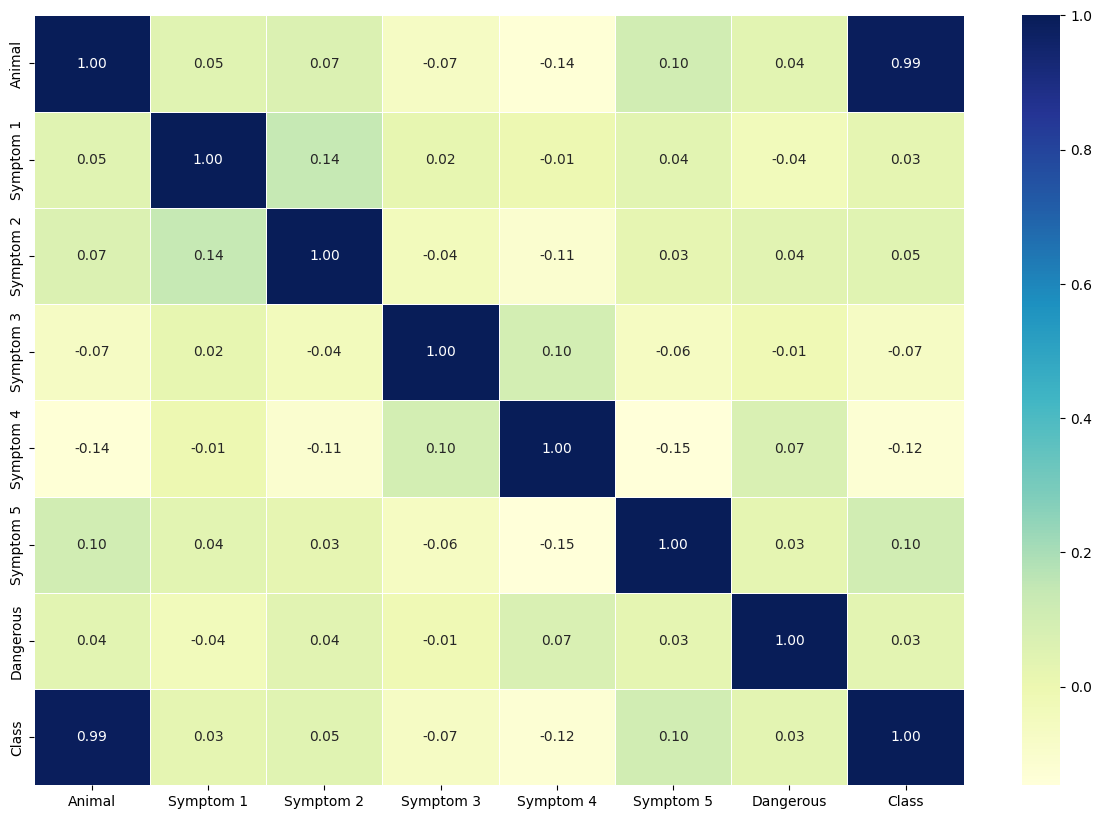

In [12]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, 
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

In [83]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Top Absolute Correlations
Animal     Class        0.987089
Symptom 4  Symptom 5    0.146871
Symptom 1  Symptom 2    0.142364
Animal     Symptom 4    0.135607
Symptom 4  Class        0.121414
Symptom 2  Symptom 4    0.106580
Symptom 5  Class        0.102093
Animal     Symptom 5    0.100810
Symptom 3  Symptom 4    0.098226
Symptom 4  Dangerous    0.073928
dtype: float64


## 4. Particion de datos y algoritmo de Machine Learning
Trabaje con una partición de datos de entrenamiento de 80%, reserve el 20% para el testeo. Realice una explicación del algoritmo empleado (cómo funciona numéricamente).

Puntaje: 20 pts.


In [32]:
y = df['Dangerous'].to_numpy()
x1 = df[['Animal','Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']].to_numpy()
x2 = df[['Class','Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']].to_numpy()

### Particion de datos clasica con Support Vector Machines (SVM)

##### Resultados con 34 tipos de animales, dataframe original

In [15]:
#Import svm model
from sklearn import svm
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y, test_size=0.2, random_state=25)

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X1_train, y1_train)

#Predict the response for test dataset
y1_pred = clf.predict(X1_test)

precision = precision_score(y1_test, y1_pred)
recall = recall_score(y1_test, y1_pred)
accuracy = accuracy_score(y1_test, y1_pred)
tn, fp, fn, tp = confusion_matrix(y1_test, y1_pred).ravel()
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
specificity = tn / (tn+fp)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'Specificity: {specificity}')


tn: 0, fp: 5, fn: 0, tp: 169
Precision: 0.9712643678160919
Recall: 1.0
Accuracy: 0.9712643678160919
Specificity: 0.0


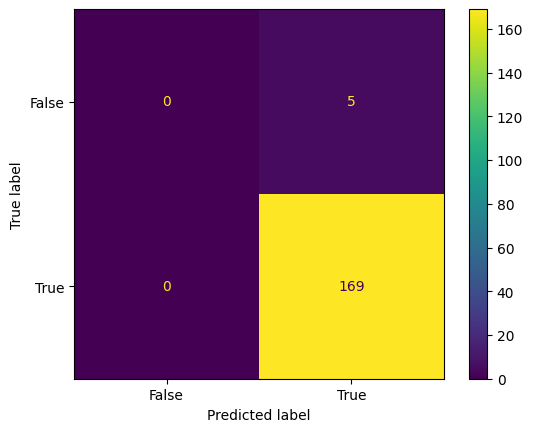

In [67]:
confusion_matrix = metrics.confusion_matrix(y1_test, y1_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

##### Resultados con 30 tipos de columnas, dataframe disminuido, especies de Ciervos agrupadas en una sola categoria


In [79]:
X2_train, X2_test, y2_train, y2_test = train_test_split(x2, y, test_size=0.2, random_state=18)

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X2_train, y2_train)

#Predict the response for test dataset
y2_pred = clf.predict(X2_test)
precision = precision_score(y2_test, y2_pred)
recall = recall_score(y2_test, y2_pred)
accuracy = accuracy_score(y2_test, y2_pred)
tn, fp, fn, tp = confusion_matrix(y2_test, y2_pred).ravel()
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
specificity = tn / (tn+fp)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'Specificity: {specificity}')

tn: 0, fp: 5, fn: 0, tp: 169
Precision: 0.9712643678160919
Recall: 1.0
Accuracy: 0.9712643678160919
Specificity: 0.0


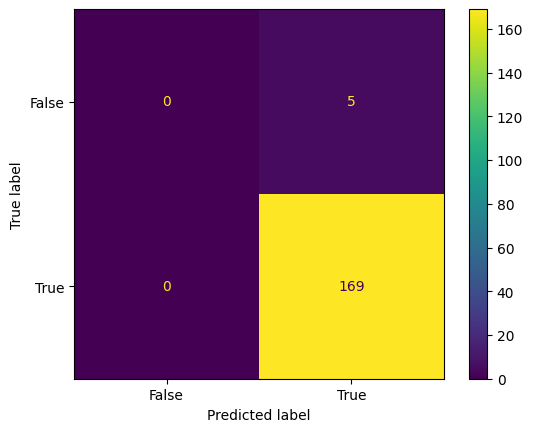

In [63]:
confusion_matrix = metrics.confusion_matrix(y2_test, y2_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

#### Resultados
Como se puede observar, no existe una diferencia al agrupar las columnas de ciervos, no tiene un impacto tangible. A continuacion se trabajara con Stratified Shuffle Split, para verficiar si existe alguna mejora en el desempeño del modelo.

### Particion con StratifiedShuffleSplit
En ciencia de datos, el Stratified Shuffle Split , también conocido como división estratificada aleatoria, es una técnica para dividir un conjunto de datos en conjuntos de entrenamiento y prueba de manera que mantenga la proporción de clases o etiquetas original en ambas particiones.  Este método es particularmente útil cuando se trabaja con conjuntos de datos desequilibrados, es decir, conjuntos de datos donde una clase puede ser mucho más común que otras.

In [33]:
from statistics import mean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
#Import svm model
from sklearn import svm

accuracy_list = []
specificity_list = []
presicion_list = []
recall_list = []
tn_list = []
fp_list = []
fn_list = []
tp_list = []

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=32)
for i, (train_index, test_index) in enumerate(sss.split(x1, y)):
    X_train, X_test = x1[train_index], x1[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)

    presicion_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    specificity_list.append(specificity)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    tp_list.append(tp)

    print(f"=================Fold #{i}=========================")
    print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
    print('Presicion: ', precision)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Specificity: ', specificity)

print('========================================')
print(f"tn Mean: {mean(tn_list)}, fp Mean: {mean(fp_list)}, fn Mean: {mean(fn_list)}, tp Mean: {mean(tp_list)}")
print('Presicion Mean: ', mean(presicion_list))
print('Recall Mean: ', mean(recall_list))
print('Accuracy Mean: ', mean(accuracy_list))
print('Specificity Mean: ', mean(specificity_list))


=================Fold #0=========================
tn: 0, fp: 4, fn: 0, tp: 170
Presicion:  0.9770114942528736
Recall:  1.0
Accuracy:  0.9770114942528736
Specificity:  0.0
=================Fold #1=========================
tn: 0, fp: 4, fn: 0, tp: 170
Presicion:  0.9770114942528736
Recall:  1.0
Accuracy:  0.9770114942528736
Specificity:  0.0
=================Fold #2=========================
tn: 0, fp: 4, fn: 0, tp: 170
Presicion:  0.9770114942528736
Recall:  1.0
Accuracy:  0.9770114942528736
Specificity:  0.0
=================Fold #3=========================
tn: 0, fp: 4, fn: 0, tp: 170
Presicion:  0.9770114942528736
Recall:  1.0
Accuracy:  0.9770114942528736
Specificity:  0.0
=================Fold #4=========================
tn: 0, fp: 4, fn: 0, tp: 170
Presicion:  0.9770114942528736
Recall:  1.0
Accuracy:  0.9770114942528736
Specificity:  0.0
tn Mean: 0, fp Mean: 4, fn Mean: 0, tp Mean: 170
Presicion Mean:  0.9770114942528736
Recall Mean:  1.0
Accuracy Mean:  0.9770114942528736
Specifi

#### Resultados
Como se puede observar, esta metodologia tiene un desempeño ligeramente mejor a la metodologia clasica. A continuacion escogeremos las columnas que tengan menor impacto y las descartaremos para evaluar si el desempeño del modelo aumenta.

### Resultados con seleccion de columnas mas influyentes
Primero debemos identificar las columnas que influyen mas en la columna de clasificacion, seguido por la influencia entre las demas columnas.

In [84]:
print(get_top_abs_correlations(df, 15))

Animal     Class        0.987089
Symptom 4  Symptom 5    0.146871
Symptom 1  Symptom 2    0.142364
Animal     Symptom 4    0.135607
Symptom 4  Class        0.121414
Symptom 2  Symptom 4    0.106580
Symptom 5  Class        0.102093
Animal     Symptom 5    0.100810
Symptom 3  Symptom 4    0.098226
Symptom 4  Dangerous    0.073928
Symptom 3  Class        0.067275
Animal     Symptom 3    0.066316
           Symptom 2    0.065323
Symptom 3  Symptom 5    0.063810
Animal     Symptom 1    0.048148
dtype: float64


como se puede observar, las columnas que muestran una correlacion mas fuerte entre si son las de "Symptom 4", "Symptom 5", "Symptom 1" y "Symptom 2", pero la que tiene una correlacion mas fuerte con Dangerous es la columna "Symptom 4", motivo por el cual se probaran los resultados con:

- "Symptom 4", "Symptom 5" y "Symptom 2"
- "Symptom 4", "Symptom 5" y "Symptom 1"
- "Symptom 4", "Symptom 1" y "Symptom 2"

Se omitira directamente la columna 3.

In [30]:
from statistics import mean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
#Import svm model
from sklearn import svm

y = df['Dangerous'].to_numpy()
x1 = df[['Animal','Symptom 1', 'Symptom 2', 'Symptom 4', 'Symptom 5']]

variable_cols = ["Symptom 5", "Symptom 1", "Symptom 2"]
for j, col in enumerate(variable_cols):
    accuracy_list = []
    specificity_list = []
    presicion_list = []
    recall_list = []
    tn_list = []
    fp_list = []
    fn_list = []
    tp_list = []

    df_xcol =  x1.drop([col], axis=1)
    Xcol =df_xcol.to_numpy()

    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=32)
    for i, (train_index, test_index) in enumerate(sss.split(x1, y)):
        X_train, X_test = Xcol[train_index], Xcol[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        #Create a svm Classifier
        clf = svm.SVC(kernel='linear') # Linear Kernel

        #Train the model using the training sets
        clf.fit(X_train, y_train)

        #Predict the response for test dataset
        y_pred = clf.predict(X_test)
        
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn+fp)

        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)

        presicion_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        specificity_list.append(specificity)

    print(f'=====================Results with Columns: {list(df_xcol.columns.values)}===================')
    print(f"tn Mean: {mean(tn_list)}, fp Mean: {mean(fp_list)}, fn Mean: {mean(fn_list)}, tp Mean: {mean(tp_list)}")
    print('Presicion Mean: ', mean(presicion_list))
    print('Recall Mean: ', mean(recall_list))
    print('Accuracy Mean: ', mean(accuracy_list))
    print('Specificity Mean: ', mean(specificity_list))
    
    

=====================Results with Columns: ['Animal', 'Symptom 1', 'Symptom 2', 'Symptom 4']===================
tn Mean: 0, fp Mean: 4, fn Mean: 0, tp Mean: 170
Presicion Mean:  0.9770114942528736
Recall Mean:  1.0
Accuracy Mean:  0.9770114942528736
Specificity Mean:  0.0
=====================Results with Columns: ['Animal', 'Symptom 2', 'Symptom 4', 'Symptom 5']===================
tn Mean: 0, fp Mean: 4, fn Mean: 0, tp Mean: 170
Presicion Mean:  0.9770114942528736
Recall Mean:  1.0
Accuracy Mean:  0.9770114942528736
Specificity Mean:  0.0
=====================Results with Columns: ['Animal', 'Symptom 1', 'Symptom 4', 'Symptom 5']===================
tn Mean: 0, fp Mean: 4, fn Mean: 0, tp Mean: 170
Presicion Mean:  0.9770114942528736
Recall Mean:  1.0
Accuracy Mean:  0.9770114942528736
Specificity Mean:  0.0


In [ ]:
confusion_matrix = metrics.confusion_matrix(y2_test, y2_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Como se puede observar, no existe un cambio en el desempeño al descartar las columnas